# LIBRERIAS Y CARGA DE DATOS

## Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from joblib import load
from statistics import mean, stdev
from os.path import join

## DATA

In [2]:
df_hogares = pd.read_csv(join("data_censo_2017", "Microdato_Censo2017-Hogares.csv"), sep=";")
df_personas = pd.read_csv(join("data_censo_2017", "Microdato_Censo2017-Personas.csv"), sep=";")
df_viviendas = pd.read_csv(join("data_censo_2017", "Microdato_Censo2017-Viviendas.csv"), sep=";")
merged_personas_hogares = df_personas.merge(df_hogares, on=['ID_ZONA_LOC', 'NVIV', 'NHOGAR'], how='left')
df_censo = merged_personas_hogares.merge(df_viviendas, on=['ID_ZONA_LOC', 'NVIV'], how='left')

## MODELOS

In [3]:
ols_model = load('modelos\OLS_2017.pkl')
rf_model = load('modelos\modelo_rf_oob_2017.joblib')
error_std = load('modelos\error_std.joblib')

## Cambio valores missing y no responde a nan

In [4]:
# Lista de columnas para reemplazar 98 y 99 por NaN
columnas_a_modificar = ['P03A', 'P03B', 'P03C', 'P04', 'P17', 'ESCOLARIDAD']

# Reemplazar 98 y 99 por NaN
df_censo[columnas_a_modificar] = df_censo[columnas_a_modificar].replace([98, 99], np.nan)

# VARIABLES DISCRETAS

In [5]:
# ** techo zinc
df_censo['techo_zinc'] = np.where(pd.isna(df_censo['P03B']), np.nan, (df_censo['P03B'] == 3).astype(int))

# ** techo paja
df_censo['techo_paja'] = np.where(pd.isna(df_censo['P03B']), np.nan, (df_censo['P03B'] == 5).astype(int))

# ** hogar urbano
df_censo['hogar_urbano'] = np.where(pd.isna(df_censo['AREA']), np.nan, (df_censo['AREA'] == 1.0).astype(int))

# ** paredes ladrillo
df_censo['paredes_ladrillo'] = np.where(pd.isna(df_censo['P03A']), np.nan, (df_censo['P03A'] == 2).astype(int))

# ** paredes madera
df_censo['paredes_madera'] = np.where(pd.isna(df_censo['P03A']), np.nan, (df_censo['P03A'].isin([3, 4]).astype(int)))

# ** piso radier
df_censo['piso_radier'] = np.where(pd.isna(df_censo['P03C']), np.nan, (df_censo['P03C'].isin([1, 2])).astype(int))

# ** piso madera
df_censo['piso_madera'] = np.where(pd.isna(df_censo['P03C']), np.nan, df_censo['P03C'] == 1)

# ** mujer jefe hogar
# Paso 1: Crear una columna temporal para identificar a las mujeres jefes de hogar
df_censo['temp_mujer_jefe'] = np.where((df_censo['P07'] == 1) & (df_censo['P08'] == 2), 1, 0)

# Paso 2: Propagar esta informacion a todo el hogar
df_censo['mujer_jefe_hogar'] = df_censo.groupby(['ID_ZONA_LOC', 'NVIV', 'NHOGAR'])['temp_mujer_jefe'].transform('max')

# Limpieza: Eliminar la columna temporal
df_censo.drop(columns='temp_mujer_jefe', inplace=True)

# ** jefe trabajo semana pasada
# Paso 1: Crear una columna temporal para identificar a los jefes de hogar que trabajaron
df_censo['temp_jefe_trabajo'] = np.where( (df_censo['P07'] == 1) & (df_censo['P17'].isin([1, 2, 3])), 1, 0)

# Paso 2: Propagar esta informacion a todo el hogar
df_censo['jefe_trabajo_semana_pasada'] = df_censo.groupby(['ID_ZONA_LOC', 'NVIV', 'NHOGAR'])['temp_jefe_trabajo'].transform('max')

# Limpieza: Eliminar la columna temporal
df_censo.drop(columns='temp_jefe_trabajo', inplace=True)


# VARIABLES CONTINUAS

In [6]:

# ** educacion jefe de hogar
# Paso 1: Crear un DataFrame con jefes de hogar y su educacion
jefes_educacion = df_censo[df_censo['P07'] == 1][['ID_ZONA_LOC', 'NVIV', 'NHOGAR', 'ESCOLARIDAD']].drop_duplicates(['ID_ZONA_LOC', 'NVIV', 'NHOGAR'])

# Paso 2: Mapear la educacion del jefe de hogar a cada miembro del hogar
df_censo = df_censo.merge(jefes_educacion, on=['ID_ZONA_LOC', 'NVIV', 'NHOGAR'], how='left', suffixes=('', '_jefe'))
df_censo['educacion_jefe_hogar'] = df_censo['ESCOLARIDAD_jefe']
df_censo.drop(columns='ESCOLARIDAD_jefe', inplace=True)

# ** numero de personas en el hogar
df_censo['numero_personas'] = df_censo.groupby(['ID_ZONA_LOC', 'NVIV', 'NHOGAR']).transform('size')

df_censo['numero_personas'] = df_censo['numero_personas'].apply(lambda x: min(x, 19))

# ** [numero de personas en el hogar]^2
df_censo['numero_personas_2'] = df_censo['numero_personas'] ** 2

# ** [numero de personas en el hogar]^3
df_censo['numero_personas_3'] = df_censo['numero_personas'] ** 3

# ** numero niños en en el hogar
# Crear una serie booleana para identificar a los niños
condicion_niños = (df_censo['P09'] >= 0) & (df_censo['P09'] <= 14)

# Asignar un valor de 1 a los niños y 0 a los no niños
df_censo['es_niño'] = condicion_niños.astype(int)

# Calcular el numero de niños en cada hogar
df_censo['numero_niños'] = df_censo.groupby(['ID_ZONA_LOC', 'NVIV', 'NHOGAR'])['es_niño'].transform('sum')

# Eliminar la columna auxiliar 'es_niño'
df_censo.drop(columns='es_niño', inplace=True)

df_censo['numero_niños'] = df_censo['numero_niños'].apply(lambda x: min(x, 9))

# ** fraccion niños
df_censo['fraccion_niños'] = df_censo['numero_niños'] / df_censo['numero_personas']

# ** numero habitaciones
df_censo['numero_habitaciones'] = df_censo['P04']

# ** numero ancianos
# Crear una serie booleana para identificar a los ancianos
condicion_ancianos = df_censo['P09'] > 65

# Asignar un valor de 1 a los ancianos y 0 a los no ancianos
df_censo['es_anciano'] = condicion_ancianos.astype(int)

# Calcular el número de ancianos en cada hogar
df_censo['numero_ancianos'] = df_censo.groupby(['ID_ZONA_LOC', 'NVIV', 'NHOGAR'])['es_anciano'].transform('sum')

# Eliminar la columna auxiliar 'es_anciano'
df_censo.drop(columns='es_anciano', inplace=True)

df_censo['numero_ancianos'] = df_censo['numero_ancianos'].apply(lambda x: min(x, 4))

# ** fraccion ancianos
df_censo['fraccion_ancianos'] = df_censo['numero_ancianos'] / df_censo['numero_personas']

# ** edad promedio hogar
df_censo['edad_promedio_hogar'] = df_censo.groupby(['ID_ZONA_LOC', 'NVIV', 'NHOGAR'])['P09'].transform('mean')

# ** [edad promedio hogar]^2
df_censo['edad_promedio_hogar_2'] = df_censo['edad_promedio_hogar'] ** 2

# ** densidad hogar
df_censo['densidad_hogar'] = df_censo['numero_personas'] / df_censo['numero_habitaciones']

# ** educacion promedio hogar
df_censo['educacion_promedio_hogar'] = df_censo.groupby(['ID_ZONA_LOC', 'NVIV', 'NHOGAR'])['ESCOLARIDAD'].transform('mean')


In [7]:
df_censo = df_censo[df_censo['numero_habitaciones'] > 0]

## CREACION DE VARIABLE: JEFE DE HOGAR PERTENECE A UN PUEBLO INDIGENA

Variable que se usa para desagregar la tasa de pobreza en diferentes grupos indigenas y los que no pertenecen a un grupo para calcular la brecha de pobreza entre los pueblos indigenas y no indigena

In [8]:
df_censo['P16A'] = df_censo['P16A'].replace(99, np.nan)

In [9]:
df_censo['etnia_jefe_hogar'] = df_censo['P16A']

In [10]:
agg_methods = {
    'REGION': 'max',
    'PROVINCIA': 'max',
    'COMUNA': 'max',
    'DC': 'max',
    'educacion_jefe_hogar': 'max',
    'techo_zinc': 'max',
    'techo_paja': 'max',
    'hogar_urbano': 'max',
    'paredes_ladrillo': 'max',
    'paredes_madera': 'max',
    'numero_personas': 'max',
    'numero_personas_2': 'max',
    'numero_niños': 'max',
    'fraccion_niños': 'max',
    'mujer_jefe_hogar': 'max',
    'numero_habitaciones': 'max',
    'densidad_hogar': 'max',
    'numero_ancianos' : 'max',
    'fraccion_ancianos': 'max',
    'numero_personas_3': 'max',
    'edad_promedio_hogar': 'max',
    'edad_promedio_hogar_2': 'max',
    'educacion_promedio_hogar': 'max',
    'piso_radier': 'max',
    'piso_madera': 'max',
    'jefe_trabajo_semana_pasada': 'max',
    'etnia_jefe_hogar': 'max'
}

df_censo_hogares = df_censo.groupby(['ID_ZONA_LOC', 'NVIV', 'NHOGAR']).agg(agg_methods).reset_index()
df_censo_hogares.dropna(inplace=True)

# CALCULO TASAS DE POBREZA

In [11]:
linea_pobreza = 158145
# Definicion de los grupos indigenas
grupos_indigenas = {1: "Mapuche", 2: "Aymara", 3: "Rapa Nui", 4: "Lican Antai", 5: "Quechua",
                    6: "Colla", 7: "Diaguita", 8: "Kawésqar", 9: "Yagán o Yamana", 10: "Otro", 98: "no indigena"}

X = df_censo_hogares[['educacion_jefe_hogar', 'techo_zinc', 'techo_paja', 'hogar_urbano', 'paredes_ladrillo', 
                      'paredes_madera', 'numero_personas', 'numero_personas_2', 'numero_niños', 'fraccion_niños', 
                      'mujer_jefe_hogar', 'numero_habitaciones', 'densidad_hogar', 'numero_ancianos', 
                      'fraccion_ancianos', 'numero_personas_3', 'edad_promedio_hogar', 'edad_promedio_hogar_2', 
                      'educacion_promedio_hogar', 'piso_radier', 'piso_madera', 'jefe_trabajo_semana_pasada']]

X = X.astype('float64')

In [12]:
# Funcion para calcular el intervalo de confianza
def calcular_intervalo_confianza(tasas):
    tasas_ordenadas = sorted(tasas)
    limite_inferior = np.percentile(tasas_ordenadas, 2.5)
    limite_superior = np.percentile(tasas_ordenadas, 97.5)
    return (limite_inferior, limite_superior)

## OLS

### ESTIMACION PUNTUAL OLS

In [25]:
# Estructuras para almacenar las tasas de pobreza
tasas_pobreza_urbano = {grupo: [] for grupo in grupos_indigenas.values()}
tasas_pobreza_rural = {grupo: [] for grupo in grupos_indigenas.values()}
tasas_pobreza_general = {grupo: [] for grupo in grupos_indigenas.values()}

# Se agrega la constante
X = sm.add_constant(X)

# Calcular predicciones
predicciones_censo = ols_model.predict(X)

predicciones_censo = np.exp(predicciones_censo)

ingreso_per_capita_predicho = predicciones_censo / (df_censo_hogares['numero_personas'] ** 0.7)
es_pobre = (ingreso_per_capita_predicho < linea_pobreza)
df_censo_hogares['clasificacion_pobreza'] = [1 if pobre else 0 for pobre in es_pobre]

for codigo, nombre_grupo in grupos_indigenas.items():
    grupo_data = df_censo_hogares[df_censo_hogares['etnia_jefe_hogar'] == codigo]
        
    # Tasa general de pobreza
    tasa_general = grupo_data['clasificacion_pobreza'].mean()
    tasas_pobreza_general[nombre_grupo].append(tasa_general)

    # Tasas de pobreza urbana y rural
    tasa_urbano = grupo_data[grupo_data['hogar_urbano'] == 1]['clasificacion_pobreza'].mean()
    tasa_rural = grupo_data[grupo_data['hogar_urbano'] == 0]['clasificacion_pobreza'].mean()
    tasas_pobreza_urbano[nombre_grupo].append(tasa_urbano)
    tasas_pobreza_rural[nombre_grupo].append(tasa_rural)

# Calcular promedios, desviaciones estandar e intervalos de confianza
resultados_finales = []
for grupo in grupos_indigenas.values():
    prom_urbano = mean(tasas_pobreza_urbano[grupo]) * 100
    prom_rural = mean(tasas_pobreza_rural[grupo]) * 100
    prom_general = mean(tasas_pobreza_general[grupo]) * 100

    resultados_finales.append({
        'Grupo': grupo,
        'Urbano': f"{prom_urbano:.2f}",
        'Rural': f"{prom_rural:.2f}",
        'General': f"{prom_general:.2f}"
    })

# Crear DataFrame para mostrar los resultados
tabla_tasas_pobreza = pd.DataFrame(resultados_finales)
tabla_tasas_pobreza

,Grupo,Urbano,Rural,General
0,Mapuche,8.08,21.87,11.86
1,Aymara,10.65,23.19,12.73
2,Rapa Nui,7.07,12.58,7.50
3,Lican Antai,7.67,10.35,8.14
4,Quechua,12.16,23.18,13.31
5,Colla,8.32,16.44,9.35
6,Diaguita,7.00,12.13,7.97
7,Kawésqar,4.69,8.45,5.05
8,Yagán o Yamana,5.50,15.15,6.43
9,Otro,8.61,22.90,12.39


### SIMULACIONES PARA CALCULAR STANDAR ERRORS E INTERVALOS DE CONFINAZA

In [26]:
# Estructuras para almacenar las tasas de pobreza
tasas_pobreza_urbano = {grupo: [] for grupo in grupos_indigenas.values()}
tasas_pobreza_rural = {grupo: [] for grupo in grupos_indigenas.values()}
tasas_pobreza_general = {grupo: [] for grupo in grupos_indigenas.values()}

# Realizar las predicciones

X = sm.add_constant(X)

# Obtener los coeficientes estimados y la matriz de varianza-covarianza
beta_estimados = ols_model.params
cov_matrix = ols_model.cov_HC3

# Error estandar del termino de error
varianza_error_estimado = ols_model.scale

# Aplicar termino de error y calcular la tasa de pobreza
for _ in range(100):

    # Generar betas aleatorios
    beta_aleatorios = np.random.multivariate_normal(beta_estimados, cov_matrix)

    # Generar termino de error aleatorio
    error_aleatorio = np.random.normal(0, np.sqrt(varianza_error_estimado), size=X.shape[0])

    # Calcular predicciones
    predicciones_censo = np.dot(X, beta_aleatorios) + error_aleatorio

    predicciones_censo = np.exp(predicciones_censo)

    ingreso_per_capita_predicho = predicciones_censo / (df_censo_hogares['numero_personas'] ** 0.7)
    es_pobre = (ingreso_per_capita_predicho < linea_pobreza)
    df_censo_hogares['clasificacion_pobreza'] = [1 if pobre else 0 for pobre in es_pobre]

    for codigo, nombre_grupo in grupos_indigenas.items():
        grupo_data = df_censo_hogares[df_censo_hogares['etnia_jefe_hogar'] == codigo]
        
        # Tasa general de pobreza
        tasa_general = grupo_data['clasificacion_pobreza'].mean()
        tasas_pobreza_general[nombre_grupo].append(tasa_general)

        # Tasas de pobreza urbana y rural
        tasa_urbano = grupo_data[grupo_data['hogar_urbano'] == 1]['clasificacion_pobreza'].mean()
        tasa_rural = grupo_data[grupo_data['hogar_urbano'] == 0]['clasificacion_pobreza'].mean()
        tasas_pobreza_urbano[nombre_grupo].append(tasa_urbano)
        tasas_pobreza_rural[nombre_grupo].append(tasa_rural)

# Calcular promedios, desviaciones estandar e intervalos de confianza
resultados_finales = []
for grupo in grupos_indigenas.values():


    ds_urbano = stdev(tasas_pobreza_urbano[grupo]) * 100
    ds_rural = stdev(tasas_pobreza_rural[grupo]) * 100
    ds_general = stdev(tasas_pobreza_general[grupo]) * 100

    resultados_finales.append({
        'Grupo': grupo,
        'Urbano': f"{ds_urbano:.2f}",
        'Rural': f"{ds_rural:.2f}",
        'General': f"{ds_general:.2f}"
    })

# Crear DataFrame para mostrar los resultados
tabla_desviaciones_pobreza = pd.DataFrame(resultados_finales)
tabla_desviaciones_pobreza

,Grupo,Urbano,Rural,General
0,Mapuche,0.38,0.60,0.43
1,Aymara,0.46,0.58,0.43
2,Rapa Nui,0.77,2.56,0.73
3,Lican Antai,0.53,1.51,0.51
4,Quechua,0.61,1.46,0.59
5,Colla,0.72,1.97,0.70
6,Diaguita,0.45,0.76,0.44
7,Kawésqar,1.06,3.71,0.99
8,Yagán o Yamana,1.51,5.58,1.50
9,Otro,0.43,0.72,0.46


In [30]:
for col in ['Urbano', 'Rural', 'General']:
    tabla_tasas_pobreza[col] = pd.to_numeric(tabla_tasas_pobreza[col], errors='coerce')
    tabla_desviaciones_pobreza[col] = pd.to_numeric(tabla_desviaciones_pobreza[col], errors='coerce')

# Calcular los intervalos de confianza
ic_inferior = tabla_tasas_pobreza[['Urbano', 'Rural', 'General']] - 1.96 * tabla_desviaciones_pobreza[['Urbano', 'Rural', 'General']]
ic_superior = tabla_tasas_pobreza[['Urbano', 'Rural', 'General']] + 1.96 * tabla_desviaciones_pobreza[['Urbano', 'Rural', 'General']]

# Formatear los intervalos de confianza y crear el DataFrame final
tabla_intervalos_confianza = pd.DataFrame({
    'Grupo': tabla_tasas_pobreza['Grupo'],
    'Urbano IC': [f"[{inf:.2f}, {sup:.2f}]" for inf, sup in zip(ic_inferior['Urbano'], ic_superior['Urbano'])],
    'Rural IC': [f"[{inf:.2f}, {sup:.2f}]" for inf, sup in zip(ic_inferior['Rural'], ic_superior['Rural'])],
    'General IC': [f"[{inf:.2f}, {sup:.2f}]" for inf, sup in zip(ic_inferior['General'], ic_superior['General'])]
})

tabla_intervalos_confianza

,Grupo,Urbano IC,Rural IC,General IC
0,Mapuche,"[7.34, 8.82]","[20.69, 23.05]","[11.02, 12.70]"
1,Aymara,"[9.75, 11.55]","[22.05, 24.33]","[11.89, 13.57]"
2,Rapa Nui,"[5.56, 8.58]","[7.56, 17.60]","[6.07, 8.93]"
3,Lican Antai,"[6.63, 8.71]","[7.39, 13.31]","[7.14, 9.14]"
4,Quechua,"[10.96, 13.36]","[20.32, 26.04]","[12.15, 14.47]"
5,Colla,"[6.91, 9.73]","[12.58, 20.30]","[7.98, 10.72]"
6,Diaguita,"[6.12, 7.88]","[10.64, 13.62]","[7.11, 8.83]"
7,Kawésqar,"[2.61, 6.77]","[1.18, 15.72]","[3.11, 6.99]"
8,Yagán o Yamana,"[2.54, 8.46]","[4.21, 26.09]","[3.49, 9.37]"
9,Otro,"[7.77, 9.45]","[21.49, 24.31]","[11.49, 13.29]"


In [31]:
# Crear un nuevo DataFrame combinando la informacion de los df anteriores
tabla_combinada = pd.DataFrame({
    'Grupo': tabla_tasas_pobreza['Grupo'],
    'Urbano': tabla_tasas_pobreza['Urbano'].astype(str) + " (" + tabla_desviaciones_pobreza['Urbano'].astype(str) + ") - " + tabla_intervalos_confianza['Urbano IC'],
    'Rural': tabla_tasas_pobreza['Rural'].astype(str) + " (" + tabla_desviaciones_pobreza['Rural'].astype(str) + ") - " + tabla_intervalos_confianza['Rural IC'],
    'General': tabla_tasas_pobreza['General'].astype(str) + " (" + tabla_desviaciones_pobreza['General'].astype(str) + ") - " + tabla_intervalos_confianza['General IC']
})

tabla_combinada

,Grupo,Urbano,Rural,General
0,Mapuche,"8.08 (0.38) - [7.34, 8.82]","21.87 (0.6) - [20.69, 23.05]","11.86 (0.43) - [11.02, 12.70]"
1,Aymara,"10.65 (0.46) - [9.75, 11.55]","23.19 (0.58) - [22.05, 24.33]","12.73 (0.43) - [11.89, 13.57]"
2,Rapa Nui,"7.07 (0.77) - [5.56, 8.58]","12.58 (2.56) - [7.56, 17.60]","7.5 (0.73) - [6.07, 8.93]"
3,Lican Antai,"7.67 (0.53) - [6.63, 8.71]","10.35 (1.51) - [7.39, 13.31]","8.14 (0.51) - [7.14, 9.14]"
4,Quechua,"12.16 (0.61) - [10.96, 13.36]","23.18 (1.46) - [20.32, 26.04]","13.31 (0.59) - [12.15, 14.47]"
5,Colla,"8.32 (0.72) - [6.91, 9.73]","16.44 (1.97) - [12.58, 20.30]","9.35 (0.7) - [7.98, 10.72]"
6,Diaguita,"7.0 (0.45) - [6.12, 7.88]","12.13 (0.76) - [10.64, 13.62]","7.97 (0.44) - [7.11, 8.83]"
7,Kawésqar,"4.69 (1.06) - [2.61, 6.77]","8.45 (3.71) - [1.18, 15.72]","5.05 (0.99) - [3.11, 6.99]"
8,Yagán o Yamana,"5.5 (1.51) - [2.54, 8.46]","15.15 (5.58) - [4.21, 26.09]","6.43 (1.5) - [3.49, 9.37]"
9,Otro,"8.61 (0.43) - [7.77, 9.45]","22.9 (0.72) - [21.49, 24.31]","12.39 (0.46) - [11.49, 13.29]"


### GRAFICO OLS

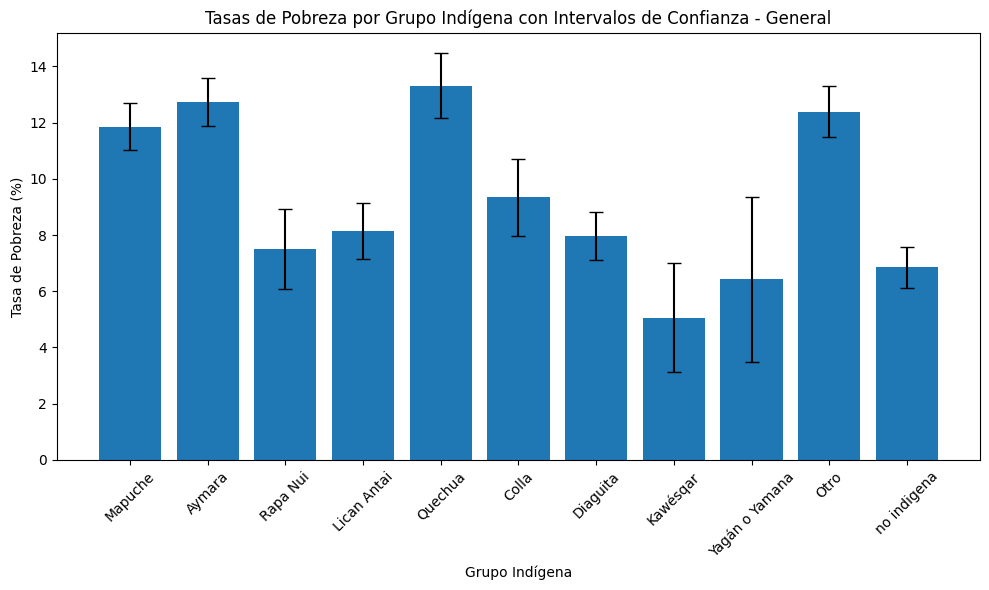

In [34]:
tasas_pobreza_general = []
intervalos_confianza_general = []

for index, row in tabla_combinada.iterrows():
    partes = row['General'].replace('[', '').replace(']', '').split()
    tasa_pobreza = float(partes[0])
    limite_inferior = float(partes[3].strip(','))
    limite_superior = float(partes[4])

    tasas_pobreza_general.append(tasa_pobreza)
    intervalos_confianza_general.append((limite_inferior, limite_superior))

# Convertir intervalos de confianza a formato adecuado para error bars
errores = [(tasa - intervalo[0], intervalo[1] - tasa) for tasa, intervalo in zip(tasas_pobreza_general, intervalos_confianza_general)]

# Graficar histograma
plt.figure(figsize=(10, 6))
bar_positions = range(len(tabla_combinada))
plt.bar(bar_positions, tasas_pobreza_general, yerr=np.transpose(errores), capsize=5)

# Etiquetas y titulo
plt.xticks(bar_positions, tabla_combinada['Grupo'], rotation=45)
plt.ylabel('Tasa de Pobreza (%)')
plt.xlabel('Grupo Indígena')
plt.title('Tasas de Pobreza por Grupo Indígena con Intervalos de Confianza - General')
plt.tight_layout()
plt.show()

## RANDOM FOREST

In [40]:
X = X.drop('const', axis=1)  # Sacamos la constante de OLS

**Estimacion puntual RF**

In [14]:
# Estructuras para almacenar las tasas de pobreza
tasas_pobreza_urbano = {grupo: [] for grupo in grupos_indigenas.values()}
tasas_pobreza_rural = {grupo: [] for grupo in grupos_indigenas.values()}
tasas_pobreza_general = {grupo: [] for grupo in grupos_indigenas.values()}

# Calcular predicciones
predicciones_censo = rf_model.predict(X)

predicciones_censo = np.exp(predicciones_censo)

ingreso_per_capita_predicho = predicciones_censo / (df_censo_hogares['numero_personas'] ** 0.7)
es_pobre = (ingreso_per_capita_predicho < linea_pobreza)
df_censo_hogares['clasificacion_pobreza'] = [1 if pobre else 0 for pobre in es_pobre]

for codigo, nombre_grupo in grupos_indigenas.items():
    grupo_data = df_censo_hogares[df_censo_hogares['etnia_jefe_hogar'] == codigo]
        
    # Tasa general de pobreza
    tasa_general = grupo_data['clasificacion_pobreza'].mean()
    tasas_pobreza_general[nombre_grupo].append(tasa_general)

    # Tasas de pobreza urbana y rural
    tasa_urbano = grupo_data[grupo_data['hogar_urbano'] == 1]['clasificacion_pobreza'].mean()
    tasa_rural = grupo_data[grupo_data['hogar_urbano'] == 0]['clasificacion_pobreza'].mean()
    tasas_pobreza_urbano[nombre_grupo].append(tasa_urbano)
    tasas_pobreza_rural[nombre_grupo].append(tasa_rural)

# Calcular promedios, desviaciones estandar e intervalos de confianza
resultados_finales = []
for grupo in grupos_indigenas.values():
    prom_urbano = mean(tasas_pobreza_urbano[grupo]) * 100
    prom_rural = mean(tasas_pobreza_rural[grupo]) * 100
    prom_general = mean(tasas_pobreza_general[grupo]) * 100

    resultados_finales.append({
        'Grupo': grupo,
        'Urbano': f"{prom_urbano:.2f}",
        'Rural': f"{prom_rural:.2f}",
        'General': f"{prom_general:.2f}"
    })

# Crear DataFrame para mostrar los resultados
tabla_tasas_pobreza = pd.DataFrame(resultados_finales)
tabla_tasas_pobreza

,Grupo,Urbano,Rural,General
0,Mapuche,2.42,7.77,3.89
1,Aymara,3.45,8.15,4.23
2,Rapa Nui,1.42,3.31,1.57
3,Lican Antai,2.45,2.11,2.39
4,Quechua,3.19,8.15,3.71
5,Colla,2.76,5.75,3.14
6,Diaguita,2.26,3.75,2.54
7,Kawésqar,1.36,2.82,1.50
8,Yagán o Yamana,1.62,0.00,1.46
9,Otro,2.44,8.89,4.14


In [43]:
# Estructuras para almacenar las tasas de pobreza
tasas_pobreza_urbano = {grupo: [] for grupo in grupos_indigenas.values()}
tasas_pobreza_rural = {grupo: [] for grupo in grupos_indigenas.values()}
tasas_pobreza_general = {grupo: [] for grupo in grupos_indigenas.values()}

predic = rf_model.predict(X)

for _ in range(20):

    # Calcular predicciones
    predicciones_censo = np.exp(predic + np.random.normal(0, error_std, size=X.shape[0]))

    ingreso_per_capita_predicho = predicciones_censo / (df_censo_hogares['numero_personas'] ** 0.7)
    es_pobre = (ingreso_per_capita_predicho < linea_pobreza)
    df_censo_hogares['clasificacion_pobreza'] = [1 if pobre else 0 for pobre in es_pobre]

    for codigo, nombre_grupo in grupos_indigenas.items():
        grupo_data = df_censo_hogares[df_censo_hogares['etnia_jefe_hogar'] == codigo]
        
        # Tasa general de pobreza
        tasa_general = grupo_data['clasificacion_pobreza'].mean()
        tasas_pobreza_general[nombre_grupo].append(tasa_general)

        # Tasas de pobreza urbana y rural
        tasa_urbano = grupo_data[grupo_data['hogar_urbano'] == 1]['clasificacion_pobreza'].mean()
        tasa_rural = grupo_data[grupo_data['hogar_urbano'] == 0]['clasificacion_pobreza'].mean()
        tasas_pobreza_urbano[nombre_grupo].append(tasa_urbano)
        tasas_pobreza_rural[nombre_grupo].append(tasa_rural)

resultados_finales = []
for grupo in grupos_indigenas.values():


    ds_urbano = stdev(tasas_pobreza_urbano[grupo]) * 100
    ds_rural = stdev(tasas_pobreza_rural[grupo]) * 100
    ds_general = stdev(tasas_pobreza_general[grupo]) * 100

    resultados_finales.append({
        'Grupo': grupo,
        'Urbano': f"{ds_urbano:.2f}",
        'Rural': f"{ds_rural:.2f}",
        'General': f"{ds_general:.2f}"
    })

# Crear DataFrame para mostrar los resultados
tabla_desviaciones_pobreza = pd.DataFrame(resultados_finales)
tabla_desviaciones_pobreza

,Grupo,Urbano,Rural,General
0,Mapuche,0.05,0.17,0.05
1,Aymara,0.19,0.41,0.18
2,Rapa Nui,0.55,2.65,0.52
3,Lican Antai,0.35,0.65,0.34
4,Quechua,0.48,1.01,0.48
5,Colla,0.52,1.62,0.41
6,Diaguita,0.20,0.66,0.16
7,Kawésqar,0.67,3.20,0.73
8,Yagán o Yamana,1.34,4.33,1.19
9,Otro,0.17,0.30,0.17


In [44]:
for col in ['Urbano', 'Rural', 'General']:
    tabla_tasas_pobreza[col] = pd.to_numeric(tabla_tasas_pobreza[col], errors='coerce')
    tabla_desviaciones_pobreza[col] = pd.to_numeric(tabla_desviaciones_pobreza[col], errors='coerce')

# Calcular los intervalos de confianza
ic_inferior = tabla_tasas_pobreza[['Urbano', 'Rural', 'General']] - 1.96 * tabla_desviaciones_pobreza[['Urbano', 'Rural', 'General']]
ic_superior = tabla_tasas_pobreza[['Urbano', 'Rural', 'General']] + 1.96 * tabla_desviaciones_pobreza[['Urbano', 'Rural', 'General']]

# Formatear los intervalos de confianza y crear el DataFrame final
tabla_intervalos_confianza = pd.DataFrame({
    'Grupo': tabla_tasas_pobreza['Grupo'],
    'Urbano IC': [f"[{inf:.2f}, {sup:.2f}]" for inf, sup in zip(ic_inferior['Urbano'], ic_superior['Urbano'])],
    'Rural IC': [f"[{inf:.2f}, {sup:.2f}]" for inf, sup in zip(ic_inferior['Rural'], ic_superior['Rural'])],
    'General IC': [f"[{inf:.2f}, {sup:.2f}]" for inf, sup in zip(ic_inferior['General'], ic_superior['General'])]
})

tabla_intervalos_confianza

,Grupo,Urbano IC,Rural IC,General IC
0,Mapuche,"[2.32, 2.52]","[7.44, 8.10]","[3.79, 3.99]"
1,Aymara,"[3.08, 3.82]","[7.35, 8.95]","[3.88, 4.58]"
2,Rapa Nui,"[0.34, 2.50]","[-1.88, 8.50]","[0.55, 2.59]"
3,Lican Antai,"[1.76, 3.14]","[0.84, 3.38]","[1.72, 3.06]"
4,Quechua,"[2.25, 4.13]","[6.17, 10.13]","[2.77, 4.65]"
5,Colla,"[1.74, 3.78]","[2.57, 8.93]","[2.34, 3.94]"
6,Diaguita,"[1.87, 2.65]","[2.46, 5.04]","[2.23, 2.85]"
7,Kawésqar,"[0.05, 2.67]","[-3.45, 9.09]","[0.07, 2.93]"
8,Yagán o Yamana,"[-1.01, 4.25]","[-8.49, 8.49]","[-0.87, 3.79]"
9,Otro,"[2.11, 2.77]","[8.30, 9.48]","[3.81, 4.47]"


In [45]:
# Crear un nuevo DataFrame combinando la informacion de los df anteriores
tabla_combinada = pd.DataFrame({
    'Grupo': tabla_tasas_pobreza['Grupo'],
    'Urbano': tabla_tasas_pobreza['Urbano'].astype(str) + " (" + tabla_desviaciones_pobreza['Urbano'].astype(str) + ") - " + tabla_intervalos_confianza['Urbano IC'],
    'Rural': tabla_tasas_pobreza['Rural'].astype(str) + " (" + tabla_desviaciones_pobreza['Rural'].astype(str) + ") - " + tabla_intervalos_confianza['Rural IC'],
    'General': tabla_tasas_pobreza['General'].astype(str) + " (" + tabla_desviaciones_pobreza['General'].astype(str) + ") - " + tabla_intervalos_confianza['General IC']
})

tabla_combinada

,Grupo,Urbano,Rural,General
0,Mapuche,"2.42 (0.05) - [2.32, 2.52]","7.77 (0.17) - [7.44, 8.10]","3.89 (0.05) - [3.79, 3.99]"
1,Aymara,"3.45 (0.19) - [3.08, 3.82]","8.15 (0.41) - [7.35, 8.95]","4.23 (0.18) - [3.88, 4.58]"
2,Rapa Nui,"1.42 (0.55) - [0.34, 2.50]","3.31 (2.65) - [-1.88, 8.50]","1.57 (0.52) - [0.55, 2.59]"
3,Lican Antai,"2.45 (0.35) - [1.76, 3.14]","2.11 (0.65) - [0.84, 3.38]","2.39 (0.34) - [1.72, 3.06]"
4,Quechua,"3.19 (0.48) - [2.25, 4.13]","8.15 (1.01) - [6.17, 10.13]","3.71 (0.48) - [2.77, 4.65]"
5,Colla,"2.76 (0.52) - [1.74, 3.78]","5.75 (1.62) - [2.57, 8.93]","3.14 (0.41) - [2.34, 3.94]"
6,Diaguita,"2.26 (0.2) - [1.87, 2.65]","3.75 (0.66) - [2.46, 5.04]","2.54 (0.16) - [2.23, 2.85]"
7,Kawésqar,"1.36 (0.67) - [0.05, 2.67]","2.82 (3.2) - [-3.45, 9.09]","1.5 (0.73) - [0.07, 2.93]"
8,Yagán o Yamana,"1.62 (1.34) - [-1.01, 4.25]","0.0 (4.33) - [-8.49, 8.49]","1.46 (1.19) - [-0.87, 3.79]"
9,Otro,"2.44 (0.17) - [2.11, 2.77]","8.89 (0.3) - [8.30, 9.48]","4.14 (0.17) - [3.81, 4.47]"


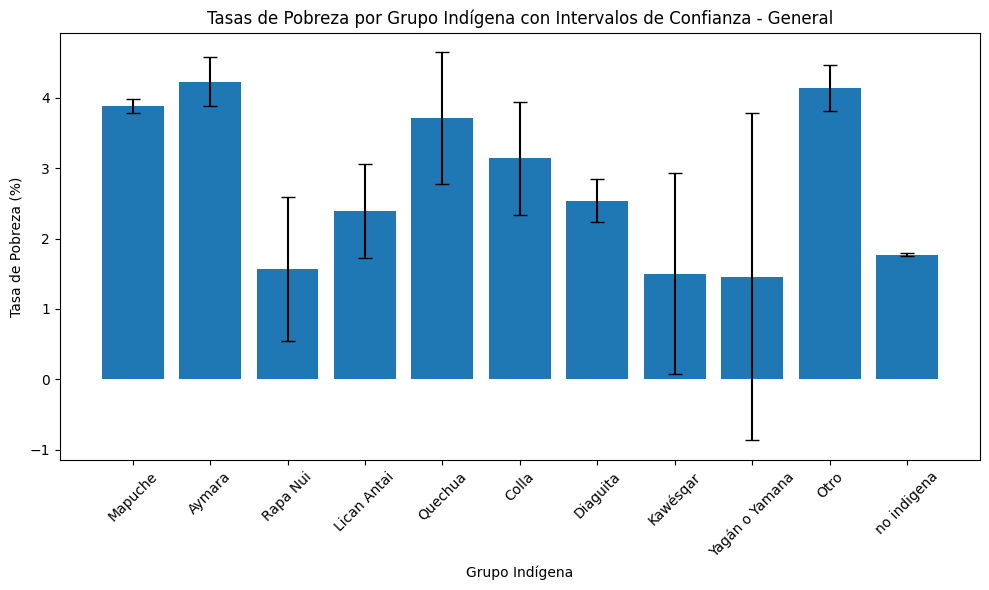

In [46]:
tasas_pobreza_general = []
intervalos_confianza_general = []

for index, row in tabla_combinada.iterrows():
    partes = row['General'].replace('[', '').replace(']', '').split()
    tasa_pobreza = float(partes[0])
    limite_inferior = float(partes[3].strip(','))
    limite_superior = float(partes[4])

    tasas_pobreza_general.append(tasa_pobreza)
    intervalos_confianza_general.append((limite_inferior, limite_superior))

# Convertir intervalos de confianza a formato adecuado para error bars
errores = [(tasa - intervalo[0], intervalo[1] - tasa) for tasa, intervalo in zip(tasas_pobreza_general, intervalos_confianza_general)]

# Graficar histograma
plt.figure(figsize=(10, 6))
bar_positions = range(len(tabla_combinada))
plt.bar(bar_positions, tasas_pobreza_general, yerr=np.transpose(errores), capsize=5)

# Etiquetas y titulo
plt.xticks(bar_positions, tabla_combinada['Grupo'], rotation=45)
plt.ylabel('Tasa de Pobreza (%)')
plt.xlabel('Grupo Indígena')
plt.title('Tasas de Pobreza por Grupo Indígena con Intervalos de Confianza - General')
plt.tight_layout()
plt.show()

### Nivel hogares

Se define linea de pobreza y se carga el modelo

In [19]:


# Estructuras para almacenar las tasas de pobreza
tasas_pobreza_urbano = {grupo: [] for grupo in grupos_indigenas.values()}
tasas_pobreza_rural = {grupo: [] for grupo in grupos_indigenas.values()}
tasas_pobreza_general = {grupo: [] for grupo in grupos_indigenas.values()}

# Realizar las predicciones
X = df_censo_hogares[['educacion_jefe_hogar', 'techo_zinc', 'techo_paja', 'hogar_urbano', 'paredes_ladrillo', 
                      'paredes_madera', 'numero_personas', 'numero_personas_2', 'numero_niños', 'fraccion_niños', 
                      'mujer_jefe_hogar', 'numero_habitaciones', 'densidad_hogar', 'numero_ancianos', 
                      'fraccion_ancianos', 'numero_personas_3', 'edad_promedio_hogar', 'edad_promedio_hogar_2', 
                      'educacion_promedio_hogar', 'piso_radier', 'piso_madera', 'jefe_trabajo_semana_pasada']]

predic = rf_model.predict(X)

# Aplicar termino de error y calcular la tasa de pobreza
for _ in range(1000):
    predicciones_censo = np.exp(predic + np.random.normal(0, error_std, size=X.shape[0]))
    ingreso_per_capita_predicho = predicciones_censo / (df_censo_hogares['numero_personas'] ** 0.7)
    es_pobre = (ingreso_per_capita_predicho < linea_pobreza)
    df_censo_hogares['clasificacion_pobreza'] = [1 if pobre else 0 for pobre in es_pobre]

    for codigo, nombre_grupo in grupos_indigenas.items():
        grupo_data = df_censo_hogares[df_censo_hogares['etnia_jefe_hogar'] == codigo]
        
        # Tasa general de pobreza
        tasa_general = grupo_data['clasificacion_pobreza'].mean()
        tasas_pobreza_general[nombre_grupo].append(tasa_general)

        # Tasas de pobreza urbana y rural
        tasa_urbano = grupo_data[grupo_data['hogar_urbano'] == 1]['clasificacion_pobreza'].mean()
        tasa_rural = grupo_data[grupo_data['hogar_urbano'] == 0]['clasificacion_pobreza'].mean()
        tasas_pobreza_urbano[nombre_grupo].append(tasa_urbano)
        tasas_pobreza_rural[nombre_grupo].append(tasa_rural)



# Calcular promedios, desviaciones estandar e intervalos de confianza
resultados_finales = []
for grupo in grupos_indigenas.values():
    prom_urbano = mean(tasas_pobreza_urbano[grupo]) * 100
    prom_rural = mean(tasas_pobreza_rural[grupo]) * 100
    prom_general = mean(tasas_pobreza_general[grupo]) * 100

    ds_urbano = stdev(tasas_pobreza_urbano[grupo]) * 100
    ds_rural = stdev(tasas_pobreza_rural[grupo]) * 100
    ds_general = stdev(tasas_pobreza_general[grupo]) * 100

    intervalo_urbano = calcular_intervalo_confianza(tasas_pobreza_urbano[grupo])
    intervalo_rural = calcular_intervalo_confianza(tasas_pobreza_rural[grupo])
    intervalo_general = calcular_intervalo_confianza(tasas_pobreza_general[grupo])

    resultados_finales.append({
        'Grupo': grupo,
        'Urbano': f"{prom_urbano:.2f} ({ds_urbano:.2f}) - [{intervalo_urbano[0]*100:.2f}, {intervalo_urbano[1]*100:.2f}]",
        'Rural': f"{prom_rural:.2f} ({ds_rural:.2f}) - [{intervalo_rural[0]*100:.2f}, {intervalo_rural[1]*100:.2f}]",
        'General': f"{prom_general:.2f} ({ds_general:.2f}) - [{intervalo_general[0]*100:.2f}, {intervalo_general[1]*100:.2f}]"
    })

# Crear DataFrame para mostrar los resultados
tabla_tasas_pobreza = pd.DataFrame(resultados_finales)

In [20]:
# Aplicar estilos a la tabla
tabla_estilizada = tabla_tasas_pobreza.style.set_table_styles(
    [{'selector': 'th', 
      'props': [('font-size', '12pt'), 
                ('text-align', 'center'), 
                ('background-color', '#4f81bd'), 
                ('color', 'white')]},
     {'selector': 'td', 
      'props': [('text-align', 'center'), 
                ('background-color', '#d9e5f5'), 
                ('color', 'black')]},
     {'selector': 'tr:hover', 
      'props': [('background-color', '#b8cce4')]}
    ]).set_properties(**{'border-color': 'black', 'border-width': '1px', 'border-style': 'solid'})

tabla_estilizada


,Grupo,Urbano,Rural,General
0,Mapuche,"8.58 (0.05) - [8.48, 8.69]","19.00 (0.12) - [18.77, 19.22]","11.44 (0.05) - [11.34, 11.53]"
1,Aymara,"10.14 (0.17) - [9.79, 10.49]","16.20 (0.48) - [15.20, 17.12]","11.14 (0.16) - [10.83, 11.47]"
2,Rapa Nui,"7.06 (0.54) - [6.04, 8.09]","10.34 (2.30) - [5.96, 15.23]","7.32 (0.53) - [6.29, 8.34]"
3,Lican Antai,"8.73 (0.36) - [8.03, 9.45]","10.01 (0.86) - [8.24, 11.76]","8.95 (0.33) - [8.26, 9.59]"
4,Quechua,"10.60 (0.35) - [9.93, 11.29]","16.22 (1.17) - [14.16, 18.60]","11.19 (0.34) - [10.54, 11.86]"
5,Colla,"8.51 (0.49) - [7.60, 9.52]","12.85 (1.48) - [9.86, 15.89]","9.07 (0.47) - [8.16, 10.01]"
6,Diaguita,"7.65 (0.22) - [7.21, 8.08]","11.51 (0.53) - [10.48, 12.59]","8.38 (0.21) - [7.99, 8.78]"
7,Kawésqar,"5.31 (0.79) - [3.93, 6.96]","8.40 (2.85) - [2.82, 14.08]","5.61 (0.76) - [4.23, 7.10]"
8,Yagán o Yamana,"6.22 (1.23) - [3.88, 8.74]","9.38 (4.86) - [0.00, 18.18]","6.52 (1.21) - [4.09, 8.77]"
9,Otro,"8.55 (0.16) - [8.23, 8.86]","19.34 (0.38) - [18.61, 20.05]","11.40 (0.15) - [11.10, 11.69]"


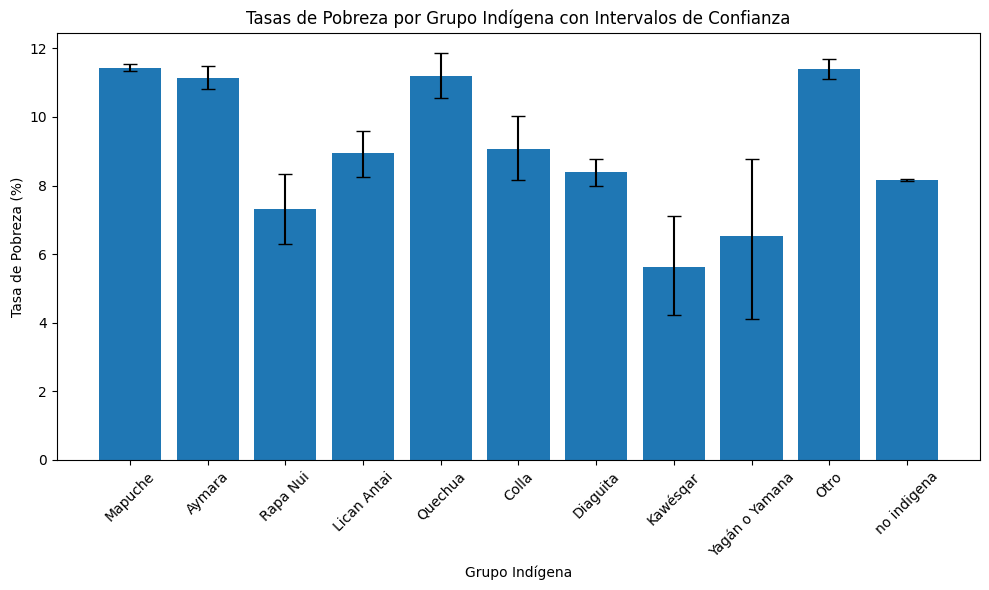

In [21]:
# Extraccion de tasas de pobreza y sus intervalos de confianza
tasas_pobreza = [mean(tasas_pobreza_general[grupo]) * 100 for grupo in grupos_indigenas.values()]
intervalos_confianza = [calcular_intervalo_confianza(tasas_pobreza_general[grupo]) for grupo in grupos_indigenas.values()]

# Convertir intervalos de confianza a formato adecuado para error bars
errores = [(tasa - intervalo[0]*100, intervalo[1]*100 - tasa) for tasa, intervalo in zip(tasas_pobreza, intervalos_confianza)]

# Graficar histograma
plt.figure(figsize=(10, 6))
bar_positions = range(len(grupos_indigenas))
plt.bar(bar_positions, tasas_pobreza, yerr=np.transpose(errores), capsize=5)

# Etiquetas y titulo
plt.xticks(bar_positions, grupos_indigenas.values(), rotation=45)
plt.ylabel('Tasa de Pobreza (%)')
plt.xlabel('Grupo Indígena')
plt.title('Tasas de Pobreza por Grupo Indígena con Intervalos de Confianza')
plt.tight_layout()
plt.show()